In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names-shuffled.txt', 'r').read().splitlines()

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k, v in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

27


In [33]:
# change the context length to 8
context_length = 8 # context length: number of chars used to predict the next char

def build_dataset(words):
    X, Y = [], [] # inputs and labels

    for w in words:
        context = [0] * context_length
        for c in w + '.':
            X.append(context)
            Y.append(stoi[c])
            context = context[1:] + [stoi[c]] # sliding the context by 1 character to right

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

torch.Size([404639, 8]) torch.Size([404639])
torch.Size([50467, 8]) torch.Size([50467])
torch.Size([50351, 8]) torch.Size([50351])


In [34]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join([itos[c.item()] for c in x]), "-->", itos[y.item()])

........ --> k
.......k --> a
......ka --> a
.....kaa --> r
....kaar --> u
...kaaru --> n
..kaarun --> y
.kaaruny --> a
kaarunya --> n
aarunyan --> .
........ --> v
.......v --> i
......vi --> b
.....vib --> h
....vibh --> u
...vibhu --> m
..vibhum --> .
........ --> a
.......a --> n
......an --> i


In [35]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1D:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.momentum = momentum
        self.eps = eps
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x: torch.Tensor):

        # during training calculate the batch statistics
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        # while inference use running statistics
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xnorm = (x - xmean)/torch.sqrt(xvar+self.eps)
        self.out = self.gamma * xnorm + self.beta

        # during training calculate the running statistics
        # during inference these are fixed
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var  = (1-self.momentum)*self.running_var  + self.momentum*xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
# ---------- new classes ----------

class Embedding: # equivalent to emb = C[Xb]
    def __init__(self, vocab_size, n_emb_dim):
        self.weight = torch.randn((vocab_size, n_emb_dim))
    def __call__(self, IX):
        return self.weight[IX]
    def parameters(self):
        return [self.weight]
    
class Flatten: # equivalent to x = emb.view(-1, context_length*n_emb_dim) # 24x30
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

In [36]:
torch.manual_seed(42);

In [37]:
n_emb_dim = 10    # embedding dimensionality
n_hidden = 200    # neurons in hidden layers

# C = torch.randn((vocab_size, n_emb_dim)) # moved to model class as Embedding layer

model = Sequential([
     # moving the emb = C[Xb] and x = emb.view(-1, context_length*n_emb_dim) code here so that we don't have to do it manually in training loop
    Embedding(vocab_size, n_emb_dim), Flatten(),
    Linear(context_length*n_emb_dim, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # as we've BN now, we won't be changing the weights of the last layer but we'll be changing the gamma
    # gamma is multiplied with the weights in BN
    model.layers[-1].weight *= 0.1
    # layers[-1].gamma *= 0.1

    # # all other layers: apply gain
    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 1.0 # 5/3 # not required with BN

# parameters = [C] + [p for layer in layers for p in layer.parameters()]

# embedding parameters now come from the Embedding layer
parameters = model.parameters()


print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [38]:
epochs = 200000
batch_size = 24
lossi = []

for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    # this has been moved to the model above
    # emb = C[Xb] # 24x3x10
    # x = emb.view(-1, context_length*n_emb_dim) # 24x30

    # x = Xb
    # for layer in layers:
    #     x = layer(x)

    # moved the above code to the Squential class

    logits = model(Xb)

    loss = F.cross_entropy(logits, Yb)


    # zero grads
    for p in parameters:
        p.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.1 if i < 150000 else 0.01 # updated lr after introducing the BN
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2953
  10000/ 200000: 1.9752
  20000/ 200000: 2.0348
  30000/ 200000: 1.4548
  40000/ 200000: 1.7701
  50000/ 200000: 2.2711
  60000/ 200000: 2.3227
  70000/ 200000: 1.7584
  80000/ 200000: 1.8502
  90000/ 200000: 2.0718
 100000/ 200000: 1.9528
 110000/ 200000: 1.6756
 120000/ 200000: 1.3108
 130000/ 200000: 2.1620
 140000/ 200000: 1.6929
 150000/ 200000: 1.5499
 160000/ 200000: 1.7450
 170000/ 200000: 2.2507
 180000/ 200000: 2.1619
 190000/ 200000: 2.0189


We have changed the context length from 3 to 8. But this network doesn't make much sense as we're crushing way too much information way too fast.

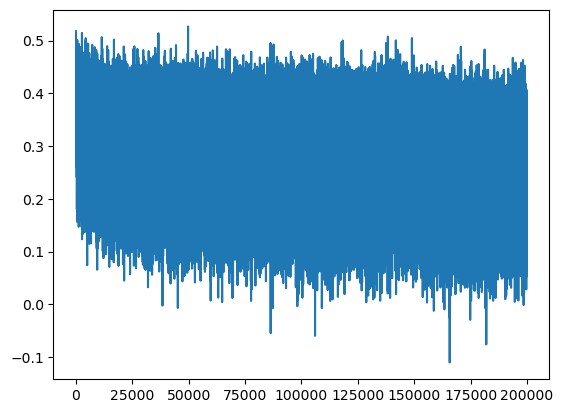

In [39]:
plt.plot(lossi);

### Smoothen the curve

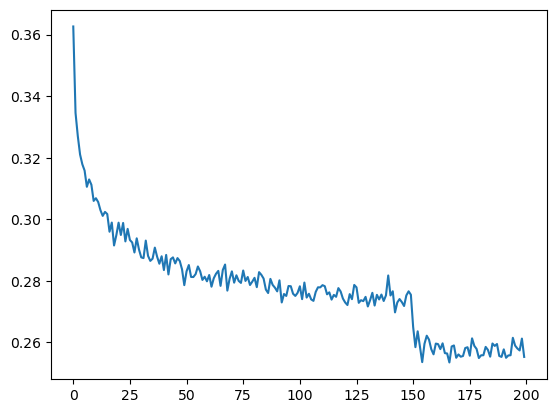

In [40]:
# lossi is of shape [200000]. We converted it to shape [200, 1000] and then took the mean of each row
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1));
# in the plot, there's a decay at 150 it is because of the change in learning rate in the training loop

In [41]:
# put layers into eval mode (needed for BN)
for layer in model.layers:
    layer.training = False

In [42]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 1.7971388101577759
dev 1.8256733417510986


#### Performance Log

- Original (3 character context + 200 hidden neurons + 12K params): train = 1.91, val = 1.92
- context: 3 -> 8 (22K params): train = 1.79, val = 1.82

In [43]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * context_length

    while True:

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join([itos[c] for c in out]))

vinonthini.
riteesh.
nityu.
medhu.
haridaa.
misho.
namali.
chandran.
charajani.
rfoon.
sathyar.
mathaakeetha.
bharsani.
migen.
analis.
mulush.
ambeeva.
kobigan.
rishmanth.
hahdumithran.
